# Spam Detection

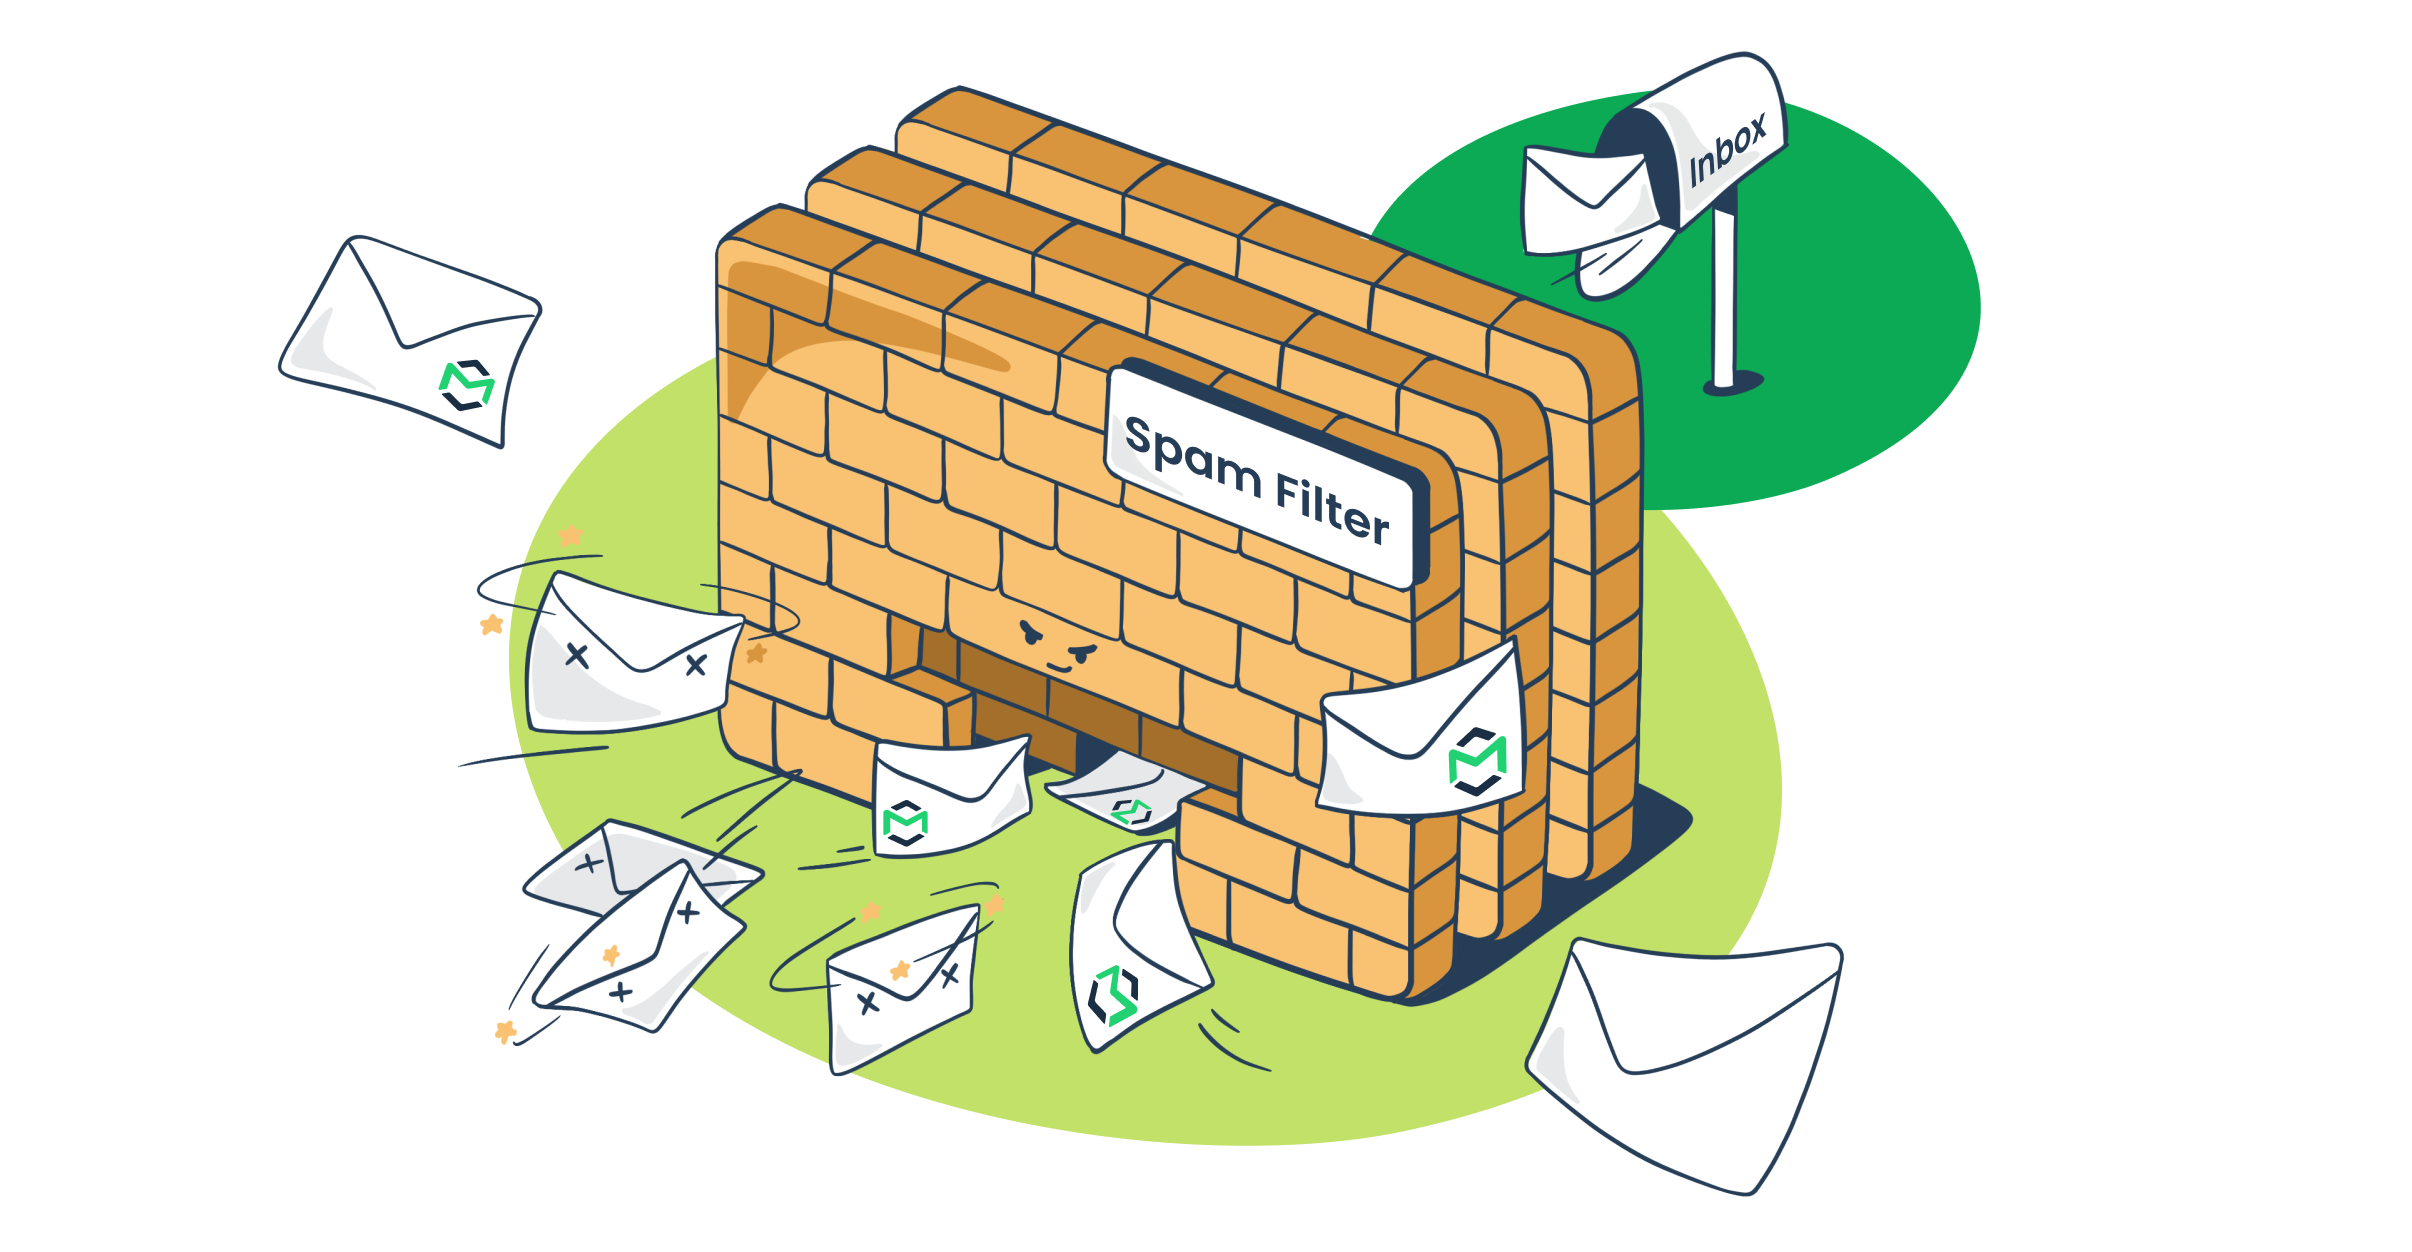

### we have Collection SMS messages that have been collected for SMS Spam research and we will use this data  to build a prediction model that will accurately classify which texts are spam


# 1- load The Data

In [46]:
#Importing libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib .pyplot as plt
import spacy
import nltk
from nltk import word_tokenize , WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
data=pd.read_csv('C:\\Users\\Ahmed\\Downloads\\spam.csv',encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [10]:
data.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [11]:
data.shape

(5572, 5)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


remove the unnecessary data and rename the columns

In [13]:
data=data.drop(labels=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
data.columns=['Labels','messages']
data.head()

,Labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 2-Exploratory Data Analysis

In [14]:
data.isnull().sum()

Labels      0
messages    0
dtype: int64

In [15]:
data.dtypes

Labels      object
messages    object
dtype: object

In [16]:
data.nunique()

Labels         2
messages    5169
dtype: int64

In [17]:
data.describe()

,Labels,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [18]:
data.groupby('Labels').describe()

messages                                                               
          count unique                                                top freq
Labels                                                                        
ham        4825   4516                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

Data visulization

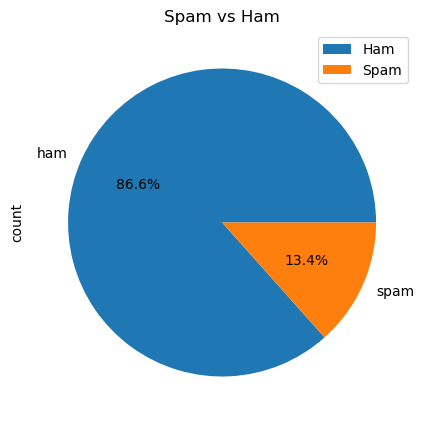

In [19]:
data["Labels"].value_counts().plot(kind = 'pie',autopct='%1.1f%%',figsize=(5,5))
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()


A lot of messages are actually not spam. About 86% of our dataset consists of normal messages

<Axes: ylabel='count'>

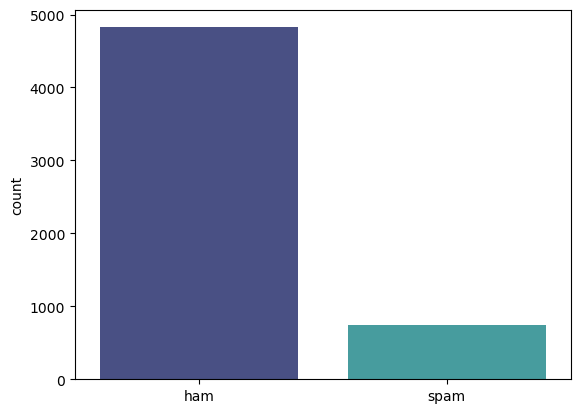

In [20]:
sns.barplot(x = data['Labels'].unique(), y = data['Labels'].value_counts(), palette= 'mako')

Note: From the above countplot the data imbalance is quite evident

# 2- Data Preprocessing

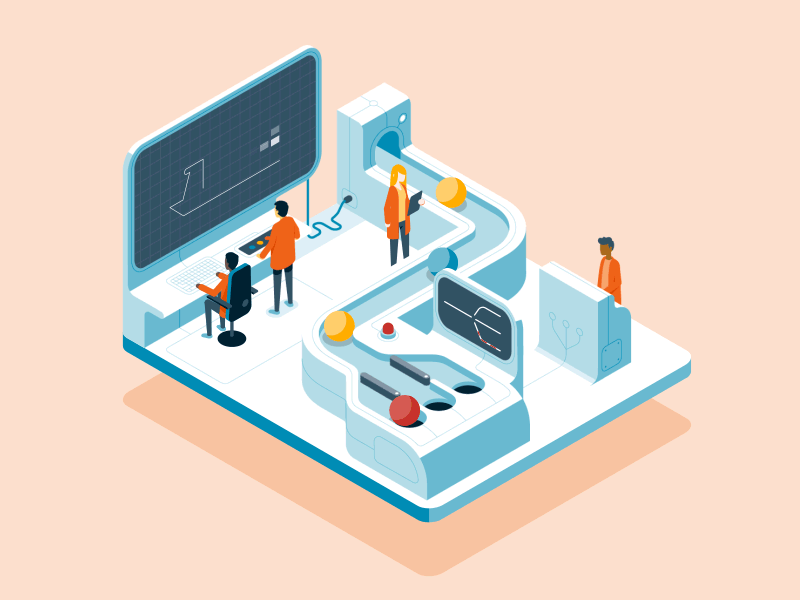

In [21]:
# Checking if there's NULLs in the data
data.isnull().sum().any()

False

In [22]:
#check if there's duplicated data
data.duplicated().any()

True

In [23]:
data.duplicated().sum()

403

In [24]:
#Removing the duplicated data
data=data.drop_duplicates()
data

,Labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [25]:
data.duplicated().any()

False

In [26]:
data['length']=data['messages'].apply(len)
data.head()

,Labels,messages,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [27]:
data['length'].describe()

count    5169.000000
mean       78.977945
std        58.236293
min         2.000000
25%        36.000000
50%        60.000000
75%       117.000000
max       910.000000
Name: length, dtype: float64

### lowercasing 

In [28]:
data['messages']=data['messages'].str.lower()
data.head()

,Labels,messages,length
0,ham,"go until jurong point, crazy.. available only ...",111
1,ham,ok lar... joking wif u oni...,29
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155
3,ham,u dun say so early hor... u c already then say...,49
4,ham,"nah i don't think he goes to usf, he lives aro...",61


### Applying word tokenizing

In [29]:
data['tokenized'] = data['messages'].apply(word_tokenize)
data.head()

,Labels,messages,length,tokenized
0,ham,"go until jurong point, crazy.. available only ...",111,"[go, until, jurong, point, ,, crazy, .., avail..."
1,ham,ok lar... joking wif u oni...,29,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor... u c already then say...,49,"[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,ham,"nah i don't think he goes to usf, he lives aro...",61,"[nah, i, do, n't, think, he, goes, to, usf, ,,..."


### Removing punctuations

In [30]:
punc = string.punctuation
data['tokenized'] = data['tokenized'].apply(lambda x: [word for word in x if word not in punc])
data.head()

,Labels,messages,length,tokenized
0,ham,"go until jurong point, crazy.. available only ...",111,"[go, until, jurong, point, crazy, .., availabl..."
1,ham,ok lar... joking wif u oni...,29,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,"[free, entry, in, 2, a, wkly, comp, to, win, f..."
3,ham,u dun say so early hor... u c already then say...,49,"[u, dun, say, so, early, hor, ..., u, c, alrea..."
4,ham,"nah i don't think he goes to usf, he lives aro...",61,"[nah, i, do, n't, think, he, goes, to, usf, he..."


### Removing stop word

In [31]:
stop_words = set(stopwords.words('english'))
data['tokenized'] = data['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

,Labels,messages,length,tokenized
0,ham,"go until jurong point, crazy.. available only ...",111,"[go, jurong, point, crazy, .., available, bugi..."
1,ham,ok lar... joking wif u oni...,29,"[ok, lar, ..., joking, wif, u, oni, ...]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,u dun say so early hor... u c already then say...,49,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,ham,"nah i don't think he goes to usf, he lives aro...",61,"[nah, n't, think, goes, usf, lives, around, th..."


### Lemmatization & Stemming

In [32]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["tokenized"] = data["tokenized"].apply(lemmatize_word)

In [33]:
data.head()

,Labels,messages,length,tokenized
0,ham,"go until jurong point, crazy.. available only ...",111,"[go, jurong, point, crazy, .., available, bugi..."
1,ham,ok lar... joking wif u oni...,29,"[ok, lar, ..., joke, wif, u, oni, ...]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,u dun say so early hor... u c already then say...,49,"[u, dun, say, early, hor, ..., u, c, already, ..."
4,ham,"nah i don't think he goes to usf, he lives aro...",61,"[nah, n't, think, go, usf, live, around, though]"


# 3-Vectorize

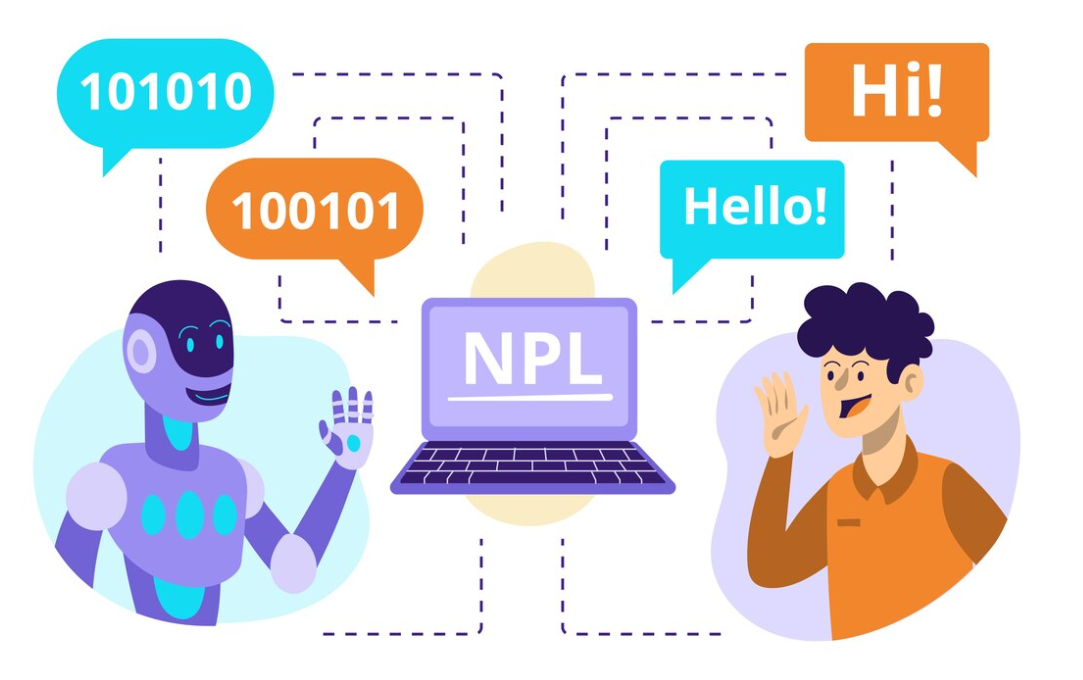

### 1)Creating a corpus of text feature to encode further into vectorized form

In [34]:
corpus= []
for i in data["tokenized"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print(corpus[:5], sep = "\n")

['go jurong point crazy .. available bugis n great world la e buffet ... cine get amore wat ...', 'ok lar ... joke wif u oni ...', "free entry 2 wkly comp win fa cup final tkts 21st may 2005. text fa 87121 receive entry question std txt rate c 's apply 08452810075over18 's", 'u dun say early hor ... u c already say ...', "nah n't think go usf live around though"]


### 2)Changing text data in to numbers. 

In [38]:
tfidf = TfidfVectorizer()
X= tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [39]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 3)Label encode the Target and use it as y

In [37]:
label_encoder = LabelEncoder()
data["Labels"] = label_encoder.fit_transform(data["Labels"])
data["Labels"]

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: Labels, Length: 5169, dtype: int32

### splite data into train & test sets


In [41]:
# Setting values for labels and feature as y and X(we already did X in vectorizing...)
Y=data['Labels']

# Splitting the testing and training sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=0.8,random_state=42)


In [42]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
Y_train

2228    0
5529    0
2149    0
5058    1
5051    0
       ..
4740    0
474     0
3266    0
4016    0
879     1
Name: Labels, Length: 4135, dtype: int32

# 5- Model Building

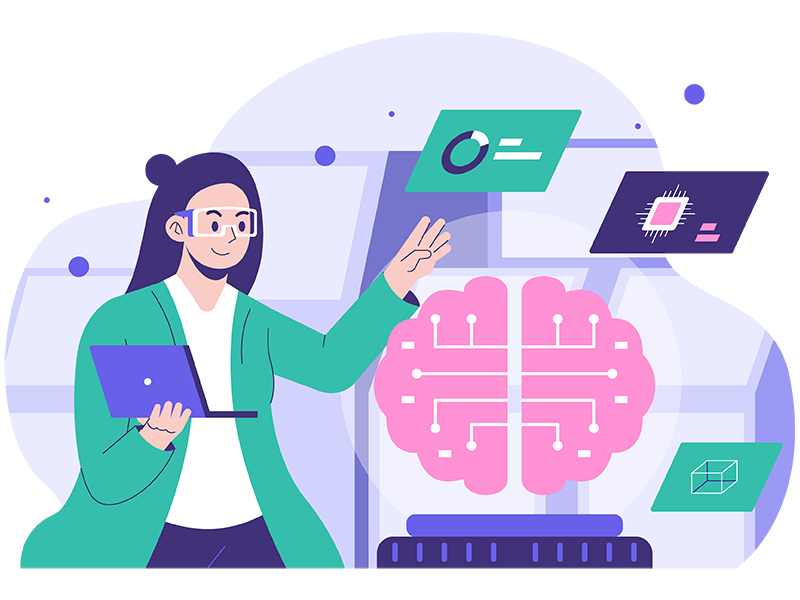

### modeling 

In [44]:
# model building 
model=MultinomialNB()
#train model by x_train,y_train
model.fit(X_train,Y_train)

MultinomialNB()

In [81]:
# accuracy for train set
print('Mean accuracy : ',cross_val_score(model, X_train, Y_train,scoring="accuracy", cv=10).mean())

Mean accuracy :  0.9571943245487828


# 6-Evaluating Model 

### Testing the model on Testset
Confusion Matrix

Accuracy Report

<Axes: >

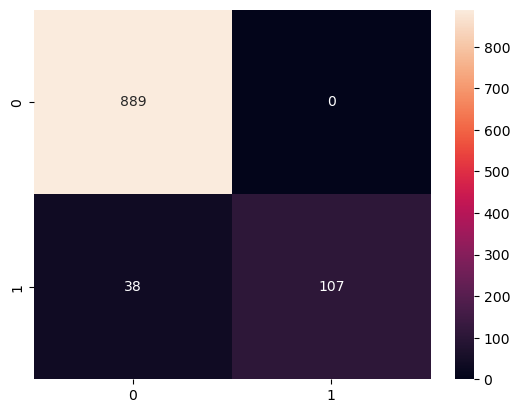

In [79]:
# confusion_matrix
pred_test = model.predict(X_test)
cm = confusion_matrix(Y_test, pred_test)
sns.heatmap(cm, annot=True, fmt="d")

 it is clearly from confusion matrix  that every item the classifier predicted as positive(hum)was indeed positive

In [70]:
#Accuracy Report

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
prec = metrics.precision_score(Y_test, pred_test)
recal = metrics.recall_score(Y_test, pred_test)
f1_s = metrics.f1_score(Y_test, pred_test)
train_accuracy = model.score(X_train,Y_train)
test_accuracy = model.score(X_test,Y_test)


In [77]:
print( f'Precision ---> {prec} \n Recall ---> {recal:.2f}\n F1score ---> {f1_s:.2f}\n Accuracy on Testset ---> {test_accuracy:.2f}\n Accuracy on Trainset---> {train_accuracy:.2f}')

Precision ---> 1.0 
 Recall ---> 0.74
 F1score ---> 0.85
 Accuracy on Testset ---> 0.96
 Accuracy on Trainset---> 0.97
